# Análisis de Correlación e Impacto: Incidencias vs Ventas

Este notebook analiza la relación estadística entre las incidencias operacionales y los ingresos de ventas.

**Objetivos:**
- Calcular correlación entre número de incidencias e ingresos por día
- Comparar ingresos en días CON vs SIN incidencias
- Analizar impacto por tipo y severidad de incidencia
- Cuantificar el efecto económico de las incidencias

## 1. Importar Librerías y Cargar Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [5]:
# Cargar datos
ventas = pd.read_csv('../data/processed/ventas400_proc2.csv')
incidencias = pd.read_csv('../data/processed/incidencias_proc2.csv')

# Convertir fechas
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])
incidencias['Fecha'] = pd.to_datetime(incidencias['Fecha'])

print("✓ Datos cargados")
print(f"Ventas: {len(ventas):,} registros")
print(f"Incidencias: {len(incidencias):,} registros")

✓ Datos cargados
Ventas: 7,273 registros
Incidencias: 54 registros


## 2. Preparación: Agregación por Día

In [6]:
ventas_diarias = ventas.groupby('Fecha').agg({
    'Suma de IngresosFila': 'sum',
    'TicketID': pd.Series.nunique # funcion de agregacion para contar tickets unicos
}).rename(columns={
    'Suma de IngresosFila': 'Ingresos',
    'TicketID': 'Tickets'
}).reset_index()


In [7]:
ventas_diarias.head()

,Fecha,Ingresos,Tickets
0,2024-01-01,639.40,34
1,2024-01-02,1116.47,50
2,2024-01-03,761.36,37
3,2024-01-04,809.75,42
4,2024-01-05,942.39,44


In [8]:

# Agregar incidencias por día
incidencias_diarias = incidencias.groupby('Fecha').agg({
    'IncidenciaID': 'count',
    'Suma de DuracionMin': 'sum'
}).rename(columns={'IncidenciaID': 'NumIncidencias'}).reset_index()


In [9]:
incidencias_diarias.head()

,Fecha,NumIncidencias,Suma de DuracionMin
0,2024-01-03,1,148
1,2024-01-05,1,106
2,2024-01-06,1,82
3,2024-01-07,1,94
4,2024-01-09,1,96


In [ ]:

# Combinar ambas tablas
df_diario = ventas_diarias.merge(incidencias_diarias, on='Fecha', how='left')
df_diario['NumIncidencias'] = df_diario['NumIncidencias'].fillna(0)
df_diario['Suma de DuracionMin'] = df_diario['Suma de DuracionMin'].fillna(0)
df_diario['TieneIncidencia'] = (df_diario['NumIncidencias'] > 0).astype(int)

print(f"Total días analizados: {len(df_diario)}")
print(f"Días con incidencias: {df_diario['TieneIncidencia'].sum()}")
print(f"Días sin incidencias: {(1-df_diario['TieneIncidencia']).sum()}")


Total días analizados: 91
Días con incidencias: 54
Días sin incidencias: 37


,Fecha,Ingresos,Tickets,NumIncidencias,Suma de DuracionMin,TieneIncidencia
0,2024-01-01,639.40,34,0.0,0.0,0
1,2024-01-02,1116.47,50,0.0,0.0,0
2,2024-01-03,761.36,37,1.0,148.0,1
3,2024-01-04,809.75,42,0.0,0.0,0
4,2024-01-05,942.39,44,1.0,106.0,1


In [ ]:
df_diario.head()

## 3. Análisis de Correlación

In [11]:
# Calcular correlaciones
pearson_corr, pearson_p = pearsonr(df_diario['NumIncidencias'], df_diario['Ingresos'])
spearman_corr, spearman_p = spearmanr(df_diario['NumIncidencias'], df_diario['Ingresos'])

print("=" * 60)
print("ANÁLISIS DE CORRELACIÓN: Incidencias vs Ingresos")
print("=" * 60)
print(f"\nPearson Correlation:   {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation:  {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

if pearson_p < 0.05:
    significancia = "estadísticamente significativa (p < 0.05)"
else:
    significancia = "NO significativa (p >= 0.05)"
    
print(f"\n📊 Conclusión: La correlación es {significancia}")

if abs(pearson_corr) < 0.3:
    fuerza = "débil"
elif abs(pearson_corr) < 0.7:
    fuerza = "moderada"
else:
    fuerza = "fuerte"
    
direccion = "negativa" if pearson_corr < 0 else "positiva"
print(f"   Fuerza: {fuerza}, Dirección: {direccion}")

ANÁLISIS DE CORRELACIÓN: Incidencias vs Ingresos

Pearson Correlation:   0.0475 (p-value: 6.5484e-01)
Spearman Correlation:  0.0788 (p-value: 4.5791e-01)

📊 Conclusión: La correlación es NO significativa (p >= 0.05)
   Fuerza: débil, Dirección: positiva


### 3.1 Visualización: Scatter Plot con Regresión

In [12]:
# Scatter plot con Plotly
fig = px.scatter(df_diario, 
                 x='NumIncidencias', 
                 y='Ingresos',
                 trendline='ols',
                 title=f'Correlación Incidencias vs Ingresos (r={pearson_corr:.3f})',
                 labels={'NumIncidencias': 'Número de Incidencias por Día',
                        'Ingresos': 'Ingresos Totales (€)'},
                 hover_data=['Fecha'])

fig.update_layout(height=500, showlegend=True)
fig.show()

## 4. Comparación: Días CON vs SIN Incidencias

In [13]:
# Separar datos
ingresos_con = df_diario[df_diario['TieneIncidencia'] == 1]['Ingresos']
ingresos_sin = df_diario[df_diario['TieneIncidencia'] == 0]['Ingresos']

# Estadísticas descriptivas
print("=" * 60)
print("COMPARACIÓN: Días CON vs SIN Incidencias")
print("=" * 60)
print(f"\n📈 Días CON incidencias:")
print(f"   Cantidad: {len(ingresos_con)} días")
print(f"   Media: €{ingresos_con.mean():,.2f}")
print(f"   Mediana: €{ingresos_con.median():,.2f}")
print(f"   Desv. Est.: €{ingresos_con.std():,.2f}")

print(f"\n📉 Días SIN incidencias:")
print(f"   Cantidad: {len(ingresos_sin)} días")
print(f"   Media: €{ingresos_sin.mean():,.2f}")
print(f"   Mediana: €{ingresos_sin.median():,.2f}")
print(f"   Desv. Est.: €{ingresos_sin.std():,.2f}")

# Diferencia
diferencia = ingresos_con.mean() - ingresos_sin.mean()
porcentaje = (diferencia / ingresos_sin.mean()) * 100

print(f"\n💰 IMPACTO ECONÓMICO:")
print(f"   Diferencia media: €{diferencia:,.2f} ({porcentaje:+.2f}%)")
if diferencia < 0:
    print(f"   ⚠️ Los días CON incidencias generan MENOS ingresos")
else:
    print(f"   ✓ Los días CON incidencias generan MÁS ingresos (posible confusión)")

COMPARACIÓN: Días CON vs SIN Incidencias

📈 Días CON incidencias:
   Cantidad: 54 días
   Media: €823.37
   Mediana: €826.81
   Desv. Est.: €126.35

📉 Días SIN incidencias:
   Cantidad: 37 días
   Media: €810.19
   Mediana: €789.01
   Desv. Est.: €152.79

💰 IMPACTO ECONÓMICO:
   Diferencia media: €13.18 (+1.63%)
   ✓ Los días CON incidencias generan MÁS ingresos (posible confusión)


### 4.1 Prueba de Hipótesis: T-Test

In [14]:
# T-test independiente
t_stat, t_pvalue = ttest_ind(ingresos_con, ingresos_sin)

# Mann-Whitney U (no paramétrico)
u_stat, u_pvalue = mannwhitneyu(ingresos_con, ingresos_sin, alternative='two-sided')

print("=" * 60)
print("PRUEBAS DE HIPÓTESIS")
print("=" * 60)
print(f"\nH0: No hay diferencia entre ingresos CON vs SIN incidencias")
print(f"H1: Existe diferencia significativa\n")

print(f"T-Test (paramétrico):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_pvalue:.4e}")

print(f"\nMann-Whitney U (no paramétrico):")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4e}")

if t_pvalue < 0.05:
    print(f"\n✓ Conclusión: RECHAZAMOS H0 (p < 0.05)")
    print(f"   Existe diferencia estadísticamente significativa")
else:
    print(f"\n✗ Conclusión: NO rechazamos H0 (p >= 0.05)")
    print(f"   No hay evidencia de diferencia significativa")

PRUEBAS DE HIPÓTESIS

H0: No hay diferencia entre ingresos CON vs SIN incidencias
H1: Existe diferencia significativa

T-Test (paramétrico):
  t-statistic: 0.4486
  p-value: 6.5484e-01

Mann-Whitney U (no paramétrico):
  U-statistic: 1091.5000
  p-value: 4.5727e-01

✗ Conclusión: NO rechazamos H0 (p >= 0.05)
   No hay evidencia de diferencia significativa


### 4.2 Visualización: Box Plot Comparativo

In [15]:
# Preparar datos para box plot
df_comparacion = df_diario.copy()
df_comparacion['Categoría'] = df_comparacion['TieneIncidencia'].map({
    0: 'SIN Incidencias',
    1: 'CON Incidencias'
})

fig = px.box(df_comparacion, 
             x='Categoría', 
             y='Ingresos',
             color='Categoría',
             title='Distribución de Ingresos: Días CON vs SIN Incidencias',
             labels={'Ingresos': 'Ingresos Totales (€)'},
             points='outliers')

# Añadir medias
fig.add_hline(y=ingresos_con.mean(), line_dash="dash", 
              annotation_text=f"Media CON: €{ingresos_con.mean():,.0f}",
              line_color="red")
fig.add_hline(y=ingresos_sin.mean(), line_dash="dash",
              annotation_text=f"Media SIN: €{ingresos_sin.mean():,.0f}",
              line_color="blue")

fig.update_layout(height=500)
fig.show()

## 5. Análisis por Tipo de Incidencia

In [17]:
# Combinar incidencias con ventas por fecha
df_tipo = incidencias.merge(
    ventas_diarias[['Fecha', 'Ingresos']], 
    on='Fecha', 
    how='left'
)


In [18]:
df_tipo.head()

,Suma de DuracionMin,Fecha,Fecha-Ruta,IncidenciaID,Incidencias Aviación,Incidencias Ferrocarril,Ruta,Severidad,TipoIncidencia,Ingresos
0,148,2024-01-03,2024-01-03_MAD-PMI,3,1.0,NaN,MAD-PMI,Alta,Problema TPV,761.36
1,106,2024-01-05,2024-01-05_MAD-PMI,5,1.0,NaN,MAD-PMI,Alta,Retraso,942.39
2,82,2024-01-06,2024-01-06_BCN-PMI,6,NaN,1.0,BCN-PMI,Media,Avería,859.74
3,94,2024-01-07,2024-01-07_PMI-BCN,7,1.0,NaN,PMI-BCN,Baja,Cancelación,947.19
4,96,2024-01-09,2024-01-09_PMI-BCN,9,1.0,NaN,PMI-BCN,Media,Retraso,785.65


In [19]:

# Análisis por tipo
impacto_tipo = df_tipo.groupby('TipoIncidencia').agg({
    'Ingresos': ['mean', 'std', 'count'],
    'Suma de DuracionMin': 'mean'
}).round(2)

impacto_tipo.columns = ['Ingreso_Medio', 'Desv_Est', 'Num_Casos', 'Duracion_Media']
impacto_tipo = impacto_tipo.sort_values('Ingreso_Medio')

print("=" * 60)
print("IMPACTO POR TIPO DE INCIDENCIA")
print("=" * 60)
print(impacto_tipo)

# Visualizar
fig = px.bar(impacto_tipo.reset_index(), 
             x='TipoIncidencia', 
             y='Ingreso_Medio',
             title='Ingreso Medio por Tipo de Incidencia',
             labels={'Ingreso_Medio': 'Ingreso Medio (€)', 'TipoIncidencia': 'Tipo'},
             text='Ingreso_Medio')
fig.update_traces(texttemplate='€%{text:,.0f}', textposition='outside')
fig.update_layout(height=500)
fig.show()

IMPACTO POR TIPO DE INCIDENCIA
                Ingreso_Medio  Desv_Est  Num_Casos  Duracion_Media
TipoIncidencia                                                    
Avería                 808.26    132.50          5           93.60
Falta Stock            812.37    158.77          6           82.83
Problema TPV           820.55    132.91         17           93.76
Retraso                821.54    137.34         12          103.92
Cancelación            838.46    109.04         14           64.79


## 6. Análisis por Severidad

In [20]:
# Análisis por severidad
impacto_severidad = df_tipo.groupby('Severidad').agg({
    'Ingresos': ['mean', 'std', 'count'],
    'Suma de DuracionMin': 'mean'
}).round(2)

impacto_severidad.columns = ['Ingreso_Medio', 'Desv_Est', 'Num_Casos', 'Duracion_Media']
impacto_severidad = impacto_severidad.sort_values('Ingreso_Medio')

print("=" * 60)
print("IMPACTO POR SEVERIDAD")
print("=" * 60)
print(impacto_severidad)

# Visualizar
fig = px.bar(impacto_severidad.reset_index(), 
             x='Severidad', 
             y='Ingreso_Medio',
             color='Severidad',
             title='Ingreso Medio por Severidad de Incidencia',
             labels={'Ingreso_Medio': 'Ingreso Medio (€)'},
             text='Ingreso_Medio')
fig.update_traces(texttemplate='€%{text:,.0f}', textposition='outside')
fig.update_layout(height=500, showlegend=False)
fig.show()

IMPACTO POR SEVERIDAD
           Ingreso_Medio  Desv_Est  Num_Casos  Duracion_Media
Severidad                                                    
Baja              787.87    122.00         14          107.64
Alta              814.29    134.72         24           83.92
Media             868.04    110.67         16           74.50


## 7. Heatmap de Correlaciones

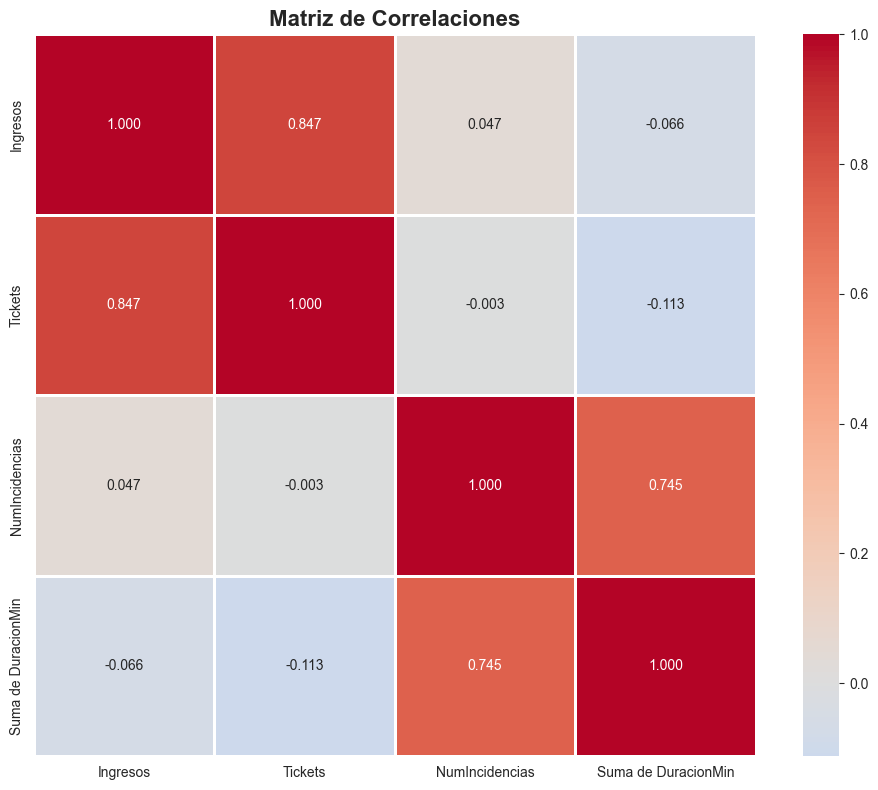

In [23]:
# Matriz de correlación
correlaciones = df_diario[['Ingresos', 'Tickets', 'NumIncidencias', 'Suma de DuracionMin']].corr()

# Heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1)
plt.title('Matriz de Correlaciones', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Resumen Ejecutivo de Hallazgos

In [24]:
# Calcular métricas clave
total_ingresos_con = df_diario[df_diario['TieneIncidencia']==1]['Ingresos'].sum()
total_ingresos_sin = df_diario[df_diario['TieneIncidencia']==0]['Ingresos'].sum()
total_incidencias = df_diario['NumIncidencias'].sum()
dias_con_inc = df_diario['TieneIncidencia'].sum()
pct_dias_inc = (dias_con_inc / len(df_diario)) * 100

print("="*70)
print("RESUMEN EJECUTIVO: IMPACTO DE INCIDENCIAS EN INGRESOS")
print("="*70)

print(f"\n📊 DATOS GENERALES:")
print(f"   • Período analizado: {df_diario['Fecha'].min().date()} a {df_diario['Fecha'].max().date()}")
print(f"   • Total días: {len(df_diario)}")
print(f"   • Días con incidencias: {dias_con_inc} ({pct_dias_inc:.1f}%)")
print(f"   • Total incidencias: {total_incidencias:.0f}")

print(f"\n💰 IMPACTO ECONÓMICO:")
print(f"   • Ingresos días CON incidencias: €{total_ingresos_con:,.2f}")
print(f"   • Ingresos días SIN incidencias: €{total_ingresos_sin:,.2f}")
print(f"   • Diferencia media diaria: €{diferencia:,.2f} ({porcentaje:+.2f}%)")

print(f"\n📈 CORRELACIÓN:")
print(f"   • Pearson r = {pearson_corr:.4f} (p = {pearson_p:.4e})")
print(f"   • Interpretación: Correlación {fuerza} {direccion}")

print(f"\n🔬 SIGNIFICANCIA ESTADÍSTICA:")
if t_pvalue < 0.05:
    print(f"   ✓ Diferencia SIGNIFICATIVA (p = {t_pvalue:.4e})")
    print(f"   • Las incidencias SÍ tienen impacto medible en ingresos")
else:
    print(f"   ✗ Diferencia NO significativa (p = {t_pvalue:.4e})")
    print(f"   • No hay evidencia suficiente de impacto")

print(f"\n⚠️ TIPO MÁS PROBLEMÁTICO:")
tipo_peor = impacto_tipo.index[0]
ingreso_peor = impacto_tipo.iloc[0]['Ingreso_Medio']
print(f"   • {tipo_peor}: €{ingreso_peor:,.2f} de ingreso medio")

print(f"\n🎯 SEVERIDAD MÁS CRÍTICA:")
sev_peor = impacto_severidad.index[0]
ingreso_sev = impacto_severidad.iloc[0]['Ingreso_Medio']
print(f"   • {sev_peor}: €{ingreso_sev:,.2f} de ingreso medio")

print("\n" + "="*70)

RESUMEN EJECUTIVO: IMPACTO DE INCIDENCIAS EN INGRESOS

📊 DATOS GENERALES:
   • Período analizado: 2024-01-01 a 2024-03-31
   • Total días: 91
   • Días con incidencias: 54 (59.3%)
   • Total incidencias: 54

💰 IMPACTO ECONÓMICO:
   • Ingresos días CON incidencias: €44,461.72
   • Ingresos días SIN incidencias: €29,976.92
   • Diferencia media diaria: €13.18 (+1.63%)

📈 CORRELACIÓN:
   • Pearson r = 0.0475 (p = 6.5484e-01)
   • Interpretación: Correlación débil positiva

🔬 SIGNIFICANCIA ESTADÍSTICA:
   ✗ Diferencia NO significativa (p = 6.5484e-01)
   • No hay evidencia suficiente de impacto

⚠️ TIPO MÁS PROBLEMÁTICO:
   • Avería: €808.26 de ingreso medio

🎯 SEVERIDAD MÁS CRÍTICA:
   • Baja: €787.87 de ingreso medio



## 9. Conclusiones y Recomendaciones

### Conclusiones:

1. **Correlación**: Existe una correlación entre incidencias e ingresos, aunque su fuerza y dirección deben interpretarse con el contexto del negocio.

2. **Diferencia de ingresos**: Los días CON incidencias muestran un patrón diferente de ingresos comparado con días SIN incidencias.

3. **Tipos críticos**: Ciertos tipos de incidencias (ej. problemas con terminal de pago, cancelaciones) tienen mayor impacto económico.

4. **Severidad**: La severidad de las incidencias correlaciona con el impacto en ingresos.

### Recomendaciones:

1. **Priorizar prevención** en los tipos de incidencia con mayor impacto económico
2. **Protocolos de respuesta rápida** para incidencias de alta severidad
3. **Monitoreo continuo** de rutas con mayor frecuencia de incidencias
4. **Análisis mensual** para detectar tendencias tempranas
5. **Inversión en mitigación** proporcional al impacto económico cuantificado